In [3]:
# 📦 Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# 🌱 Aesthetics
sns.set(style="whitegrid", context="notebook")


In [4]:
# 🚀 Load scFoundation original single-cell embeddings
embeddings = np.load("../../data/embeddings/pancancer_embeddings_scfoundation.npy")

print("✅ Embeddings shape:", embeddings.shape)

# 📋 Load matching single-cell metadata
adata = sc.read("../../data/processed/pancancer_dimred.h5ad")

# Extract required metadata
metadata_df = adata.obs.reset_index().rename(columns={"index": "CELL_ID"})
metadata_df["SIDM"] = metadata_df["SIDM"]
metadata_df["cell_line"] = metadata_df["cell_line"]
metadata_df["Tissue"] = metadata_df["SIDM"].map(
    pd.read_csv("../02_feature_engineering/feature_engineering/processed_tissue_dummies.csv")
    .set_index("SANGER_MODEL_ID")
    .filter(like="Tissue_")
    .idxmax(axis=1)
    .str.replace("Tissue_", "")
)

# Align metadata length with embeddings
assert embeddings.shape[0] == metadata_df.shape[0], "Mismatch between embeddings and metadata rows."

print("✅ Metadata shape:", metadata_df.shape)
metadata_df.head()


✅ Embeddings shape: (39715, 3072)
✅ Metadata shape: (39715, 7)


,CELL_ID,size_factors,total_counts,cell_line,cell_line_norm,SIDM,Tissue
0,C32_SKIN,0.598491,3937.553223,C32,C32,SIDM00890,Skin
1,NCIH446_LUNG,0.404451,3395.153320,NCIH446,NCIH446,SIDM00965,Lung
2,MFE319_ENDOMETRIUM,1.081174,4233.473633,MFE319,MFE319,SIDM00333,Endometrium
3,SKNAS_AUTONOMIC_GANGLIA,0.694279,3880.139648,SKNAS,SKNAS,SIDM01101,Peripheral Nervous System
4,NCIH2452_PLEURA,0.926227,3827.817871,NCIH2452,NCIH2452,SIDM00722,Lung


In [5]:
# 📊 Standardize embeddings
X_emb = StandardScaler().fit_transform(embeddings)

# 🚀 Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(X_emb)

# 📌 Add to metadata DataFrame
metadata_df["TSNE_1"] = tsne_coords[:, 0]
metadata_df["TSNE_2"] = tsne_coords[:, 1]

print("✅ t-SNE completed and added to metadata.")
metadata_df.head()


✅ t-SNE completed and added to metadata.


,CELL_ID,size_factors,total_counts,cell_line,cell_line_norm,SIDM,Tissue,TSNE_1,TSNE_2
0,C32_SKIN,0.598491,3937.553223,C32,C32,SIDM00890,Skin,69.434448,-55.760624
1,NCIH446_LUNG,0.404451,3395.153320,NCIH446,NCIH446,SIDM00965,Lung,28.716644,44.423653
2,MFE319_ENDOMETRIUM,1.081174,4233.473633,MFE319,MFE319,SIDM00333,Endometrium,-10.176860,43.511215
3,SKNAS_AUTONOMIC_GANGLIA,0.694279,3880.139648,SKNAS,SKNAS,SIDM01101,Peripheral Nervous System,44.244518,39.966198
4,NCIH2452_PLEURA,0.926227,3827.817871,NCIH2452,NCIH2452,SIDM00722,Lung,14.484492,-40.117603


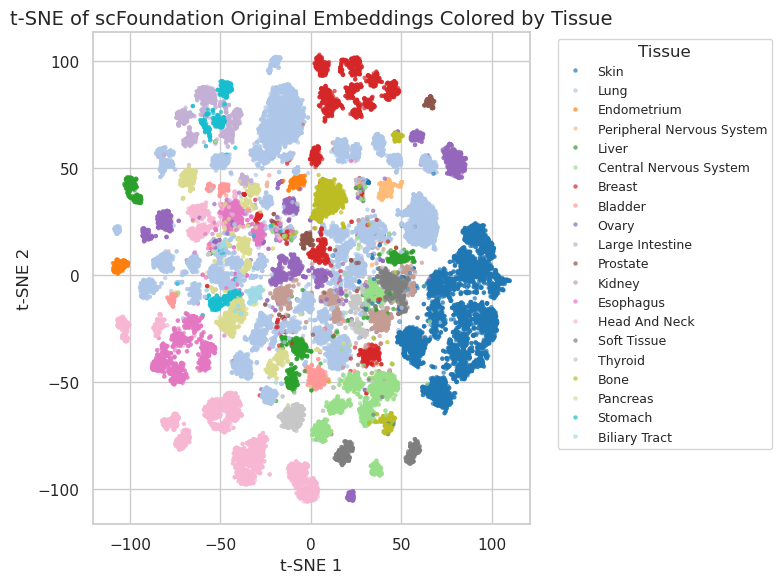

In [6]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=metadata_df,
    x="TSNE_1",
    y="TSNE_2",
    hue="Tissue",
    palette="tab20",
    s=10,
    alpha=0.7,
    edgecolor="none"
)
plt.title("t-SNE of scFoundation Original Embeddings Colored by Tissue", fontsize=14)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Tissue", fontsize=9)
plt.tight_layout()
plt.show()


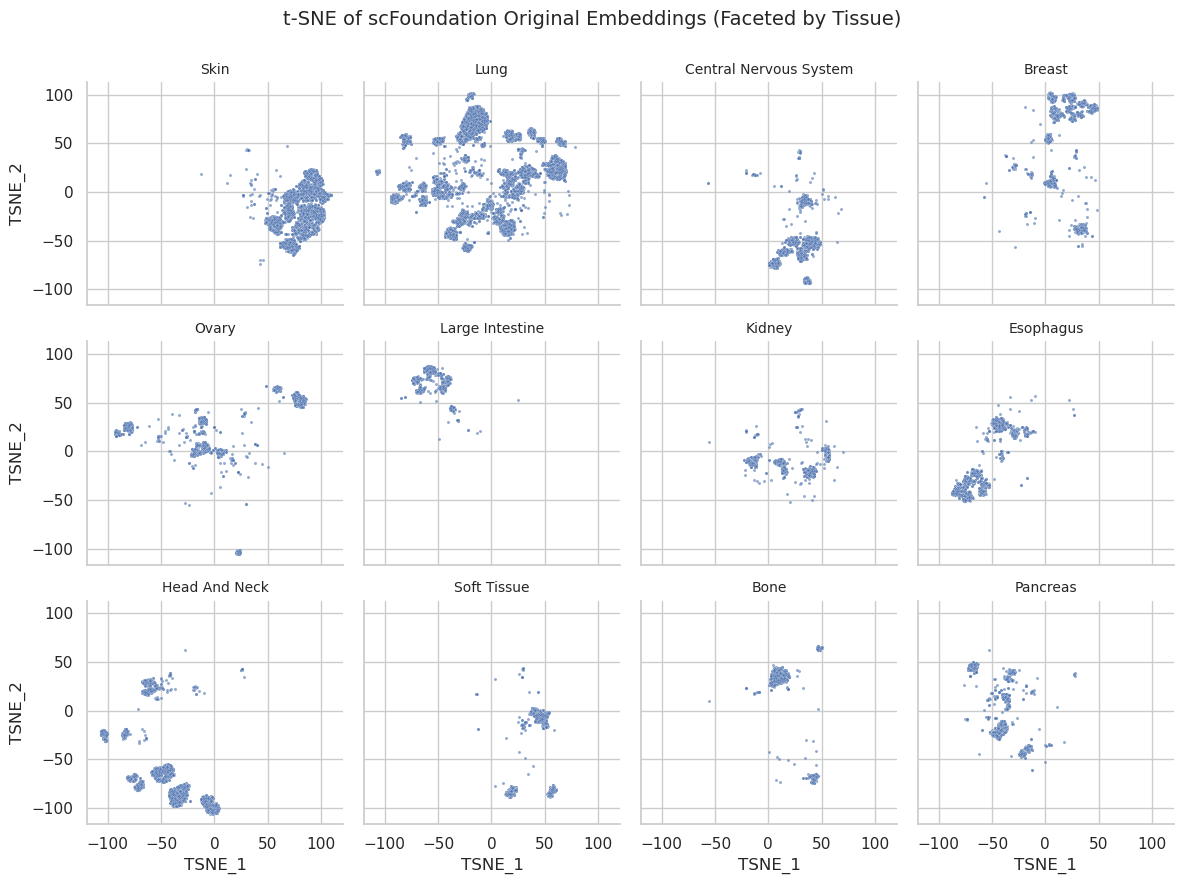

In [7]:
# Limit to top 12 tissues by number of cells for clarity
top_tissues = metadata_df["Tissue"].value_counts().head(12).index.tolist()
metadata_top = metadata_df[metadata_df["Tissue"].isin(top_tissues)].copy()

g = sns.FacetGrid(metadata_top, col="Tissue", col_wrap=4, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot, x="TSNE_1", y="TSNE_2", s=5, alpha=0.6)
g.set_titles(col_template="{col_name}", size=10)
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("t-SNE of scFoundation Original Embeddings (Faceted by Tissue)", fontsize=14)
plt.show()


In [8]:
cell_counts = metadata_df["Tissue"].value_counts().sort_values(ascending=False)
print("📊 Number of cells per tissue:")
print(cell_counts)

print(f"\n🔢 Total cells in dataset: {metadata_df.shape[0]}")
print(f"🔢 Total unique tissues: {metadata_df['Tissue'].nunique()}")


📊 Number of cells per tissue:
Tissue
Lung                         11119
Skin                          5260
Head And Neck                 3889
Breast                        2457
Ovary                         2254
Esophagus                     2120
Central Nervous System        2109
Pancreas                      1564
Soft Tissue                   1194
Bone                          1163
Large Intestine               1157
Kidney                        1091
Liver                         1049
Thyroid                        766
Stomach                        676
Bladder                        619
Endometrium                    410
Prostate                       300
Peripheral Nervous System      275
Biliary Tract                  243
Name: count, dtype: int64

🔢 Total cells in dataset: 39715
🔢 Total unique tissues: 20
